In [83]:
from sqlalchemy import create_engine
import psycopg2
import pandas as pd
from matplotlib import pyplot as plt

In [84]:
db_user = 'postgres'
db_password = 'password'
db_host = 'localhost'
db_port = '5432'
db_name = 'gas_station'

connection_string = f'postgresql+psycopg2://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}'

engine = create_engine(connection_string)

In [85]:
query = 'SELECT date, e5 FROM omv ORDER BY date'

df = pd.read_sql(query, engine)
df['e5'] /= 1000
df.set_index('date', inplace=True)
df.head()

,e5
date,
2023-01-01 04:40:09+00:00,1.659
2023-01-01 05:32:08+00:00,1.929
2023-01-01 06:33:08+00:00,1.679
2023-01-01 06:40:10+00:00,1.659
2023-01-01 11:24:09+00:00,1.709


In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17073 entries, 2023-01-01 04:40:09+00:00 to 2024-06-26 21:06:06+00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   e5      17073 non-null  float64
dtypes: float64(1)
memory usage: 266.8 KB


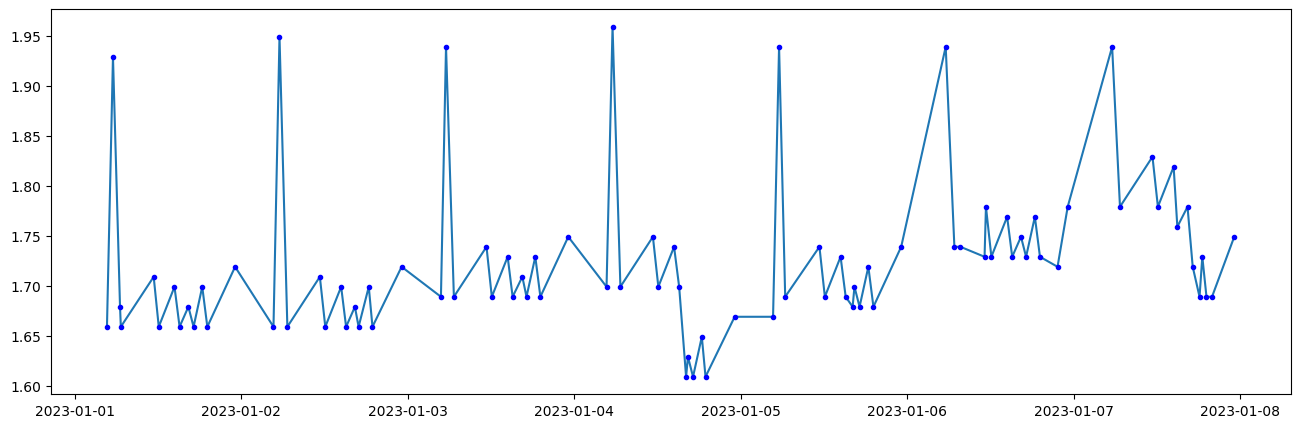

In [101]:
df_small = df['2023-01-01':'2023-01-07']

plt.figure(figsize=(16, 5))

plt.plot(df_small['e5'])
plt.plot(df_small['e5'], 'b.')

plt.show()

In [88]:
len(df)

17073

In [89]:
start_date = df.index.min().floor('30min')
end_date = df.index.max()
all_hours = pd.date_range(start=start_date, end=end_date, freq='30min')

hourly_df = pd.DataFrame(index=all_hours)
combined_df = pd.concat([df, hourly_df], axis=0).sort_index()
combined_df = combined_df[~combined_df.index.duplicated(keep='first')]

combined_df

,e5
2023-01-01 04:30:00+00:00,NaN
2023-01-01 04:40:09+00:00,1.659
2023-01-01 05:00:00+00:00,NaN
2023-01-01 05:30:00+00:00,NaN
2023-01-01 05:32:08+00:00,1.929
...,...
2024-06-26 20:00:21+00:00,1.709
2024-06-26 20:12:45+00:00,1.699
2024-06-26 20:30:00+00:00,NaN
2024-06-26 21:00:00+00:00,NaN


In [90]:
combined_df['e5'] = combined_df['e5'].interpolate(method='linear', limit_direction='both')
interpolated_df = combined_df[combined_df.index.floor('30min') == combined_df.index]

interpolated_df.head()

,e5
2023-01-01 04:30:00+00:00,1.659000
2023-01-01 05:00:00+00:00,1.749000
2023-01-01 05:30:00+00:00,1.839000
2023-01-01 06:00:00+00:00,1.845667
2023-01-01 06:30:00+00:00,1.762333


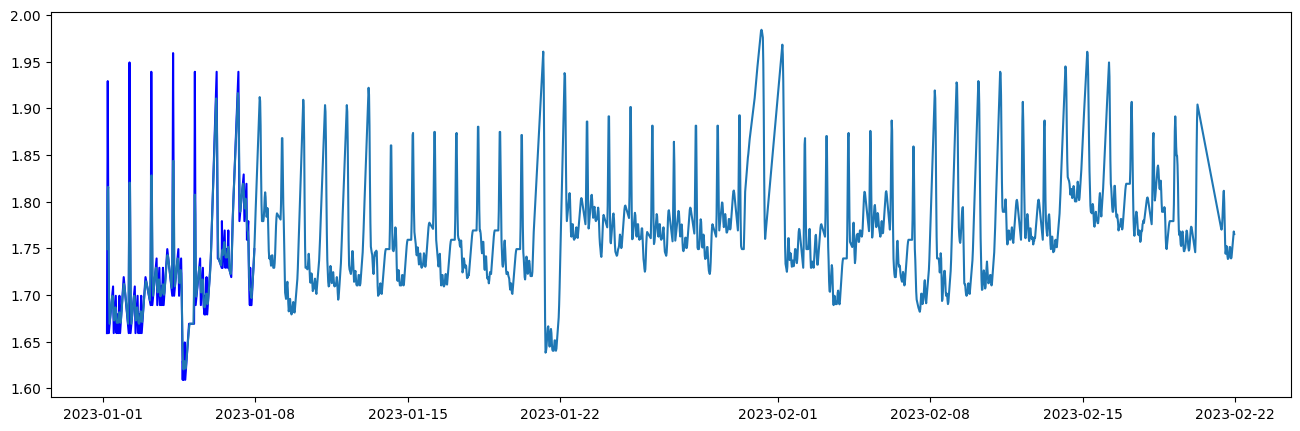

In [111]:
interpolated_df_small = interpolated_df['2023-01-01':'2023-02-21']

plt.figure(figsize=(16, 5))

plt.plot(df_small['e5'], 'b')
# plt.plot(interpolated_df_small['e5'], 'g.')
plt.plot(interpolated_df_small['e5'].rolling(window=3, center=True).mean())

plt.show()